In [1]:
# In[1]: Imports and device setup
import os
import torch
import numpy as np
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Resize, Normalize

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# In[2]: Dataset with RGB‑to‑class remapping
class MarsSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None,
                 image_suffix="img_", mask_suffix="mask_"):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # list images and masks
        self.image_files = sorted([f for f in os.listdir(image_dir)
                                   if f.startswith(image_suffix) and f.endswith(".png")])
        self.mask_files = sorted([f for f in os.listdir(mask_dir)
                                  if f.startswith(mask_suffix) and f.endswith(".png")])
        assert len(self.image_files)==len(self.mask_files), "Image/mask count mismatch"

        # expected RGB → class index
        self.rgb_to_class = {
            (0, 0, 0): 0,         # background
            (255, 255, 0): 1,     # Crater (yellow)
            (255, 0, 0): 2,       # Rough (red)
            (0, 255, 0): 3,       # Smooth (green)
            (0, 0, 255): 4        # Alluvial_Fan (blue)
        }

    def remap_mask(self, mask: Image.Image) -> np.ndarray:
        mask_arr = np.array(mask.convert("RGB"))
        h, w, _ = mask_arr.shape
        remapped = np.zeros((h, w), dtype=np.uint8)
        for rgb, cls in self.rgb_to_class.items():
            matches = np.all(mask_arr==rgb, axis=-1)
            remapped[matches] = cls
        return remapped

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir, self.image_files[idx])).convert("RGB")
        msk = Image.open(os.path.join(self.mask_dir, self.mask_files[idx]))
        msk = self.remap_mask(msk)

        if self.transform:
            aug = self.transform(image=np.array(img), mask=msk)
            img, msk = aug['image'], aug['mask']
        return img, msk.long()

In [3]:
# In[3]: Transforms and DataLoaders
transform = Compose([
    Resize(512, 512, interpolation=0),
    Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

def get_loaders(img_dir, mask_dir, transform, batch_size=8):
    ds = MarsSegmentationDataset(img_dir, mask_dir, transform)
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

train_loader = get_loaders(r"D:\u net\new base\train_images",
                           r"D:\u net\new base\train_masks",
                           transform, batch_size=8)
val_loader   = get_loaders(r"D:\u net\new base\val_image",
                           r"D:\u net\new base\val_mask",
                           transform, batch_size=8)


In [4]:
# In[4]: UNet model definition
class encoding_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, out_channels=5, features=[64,128,256,512]):
        super().__init__()
        self.pool = nn.MaxPool2d(2,2)
        # encoder
        self.enc1 = encoding_block(3, features[0])
        self.enc2 = encoding_block(features[0], features[1])
        self.enc3 = encoding_block(features[1], features[2])
        self.enc4 = encoding_block(features[2], features[3])
        self.bottleneck = encoding_block(features[3], features[3]*2)
        # decoder
        self.up1 = nn.ConvTranspose2d(features[3]*2, features[3], 2,2)
        self.dec1 = encoding_block(features[3]*2, features[3])
        self.up2 = nn.ConvTranspose2d(features[3], features[2], 2,2)
        self.dec2 = encoding_block(features[2]*2, features[2])
        self.up3 = nn.ConvTranspose2d(features[2], features[1], 2,2)
        self.dec3 = encoding_block(features[1]*2, features[1])
        self.up4 = nn.ConvTranspose2d(features[1], features[0], 2,2)
        self.dec4 = encoding_block(features[0]*2, features[0])
        self.final = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        s1 = self.enc1(x)
        s2 = self.enc2(self.pool(s1))
        s3 = self.enc3(self.pool(s2))
        s4 = self.enc4(self.pool(s3))
        b  = self.bottleneck(self.pool(s4))
        d1 = self.dec1(torch.cat([self.up1(b), s4], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d1), s3], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d2), s2], dim=1))
        d4 = self.dec4(torch.cat([self.up4(d3), s1], dim=1))
        return self.final(d4)

model = UNet(out_channels=5).to(DEVICE)


In [5]:
# In[5]: Training loop with customizable number of epochs
num_epochs = 35  # <-- Set this to any number you want

optimizer = Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs + 1):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch [{epoch}/{num_epochs}]")
    running_loss = 0.0
    for imgs, masks in loop:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg = running_loss / len(train_loader)
    print(f"Epoch {epoch} average loss: {avg:.4f}")

Epoch [1/35]: 100%|██████████████████████████████████████████████████████| 500/500 [44:17<00:00,  5.31s/it, loss=0.886]


Epoch 1 average loss: 1.0947


Epoch [2/35]: 100%|███████████████████████████████████████████████████████| 500/500 [44:25<00:00,  5.33s/it, loss=1.52]


Epoch 2 average loss: 1.0329


Epoch [3/35]: 100%|██████████████████████████████████████████████████████| 500/500 [44:14<00:00,  5.31s/it, loss=0.836]


Epoch 3 average loss: 1.0060


Epoch [4/35]: 100%|███████████████████████████████████████████████████████| 500/500 [44:18<00:00,  5.32s/it, loss=1.07]


Epoch 4 average loss: 0.9915


Epoch [5/35]: 100%|██████████████████████████████████████████████████████| 500/500 [44:14<00:00,  5.31s/it, loss=0.922]


Epoch 5 average loss: 0.9749


Epoch [6/35]: 100%|███████████████████████████████████████████████████████| 500/500 [44:16<00:00,  5.31s/it, loss=1.19]


Epoch 6 average loss: 0.9571


Epoch [7/35]: 100%|██████████████████████████████████████████████████████| 500/500 [44:14<00:00,  5.31s/it, loss=0.959]


Epoch 7 average loss: 0.9353


Epoch [8/35]: 100%|██████████████████████████████████████████████████████| 500/500 [44:25<00:00,  5.33s/it, loss=0.868]


Epoch 8 average loss: 0.9070


Epoch [9/35]: 100%|██████████████████████████████████████████████████████| 500/500 [44:28<00:00,  5.34s/it, loss=0.684]


Epoch 9 average loss: 0.8909


Epoch [10/35]: 100%|█████████████████████████████████████████████████████| 500/500 [44:13<00:00,  5.31s/it, loss=0.855]


Epoch 10 average loss: 0.8497


Epoch [11/35]: 100%|█████████████████████████████████████████████████████| 500/500 [44:12<00:00,  5.31s/it, loss=0.727]


Epoch 11 average loss: 0.8248


Epoch [12/35]: 100%|█████████████████████████████████████████████████████| 500/500 [44:13<00:00,  5.31s/it, loss=0.871]


Epoch 12 average loss: 0.7951


Epoch [13/35]: 100%|█████████████████████████████████████████████████████| 500/500 [44:13<00:00,  5.31s/it, loss=0.529]


Epoch 13 average loss: 0.7460


Epoch [14/35]: 100%|██████████████████████████████████████████████████████| 500/500 [44:13<00:00,  5.31s/it, loss=1.45]


Epoch 14 average loss: 0.7043


Epoch [15/35]: 100%|█████████████████████████████████████████████████████| 500/500 [44:12<00:00,  5.31s/it, loss=0.457]


Epoch 15 average loss: 0.6772


Epoch [16/35]: 100%|██████████████████████████████████████████████████████| 500/500 [44:13<00:00,  5.31s/it, loss=1.08]


Epoch 16 average loss: 0.6314


Epoch [17/35]: 100%|█████████████████████████████████████████████████████| 500/500 [44:14<00:00,  5.31s/it, loss=0.475]


Epoch 17 average loss: 0.6014


Epoch [18/35]: 100%|██████████████████████████████████████████████████████| 500/500 [44:12<00:00,  5.31s/it, loss=0.47]


Epoch 18 average loss: 0.5694


Epoch [19/35]: 100%|█████████████████████████████████████████████████████| 500/500 [44:13<00:00,  5.31s/it, loss=0.579]


Epoch 19 average loss: 0.5514


Epoch [20/35]: 100%|██████████████████████████████████████████████████████| 500/500 [44:14<00:00,  5.31s/it, loss=0.54]


Epoch 20 average loss: 0.5081


Epoch [21/35]: 100%|█████████████████████████████████████████████████████| 500/500 [44:43<00:00,  5.37s/it, loss=0.416]


Epoch 21 average loss: 0.4967


Epoch [22/35]: 100%|█████████████████████████████████████████████████████| 500/500 [45:21<00:00,  5.44s/it, loss=0.371]


Epoch 22 average loss: 0.4586


Epoch [23/35]: 100%|█████████████████████████████████████████████████████| 500/500 [46:01<00:00,  5.52s/it, loss=0.379]


Epoch 23 average loss: 0.4341


Epoch [24/35]: 100%|██████████████████████████████████████████████████████| 500/500 [48:03<00:00,  5.77s/it, loss=0.38]


Epoch 24 average loss: 0.4199


Epoch [25/35]: 100%|█████████████████████████████████████████████████████| 500/500 [47:35<00:00,  5.71s/it, loss=0.237]


Epoch 25 average loss: 0.3822


Epoch [26/35]: 100%|█████████████████████████████████████████████████████| 500/500 [47:28<00:00,  5.70s/it, loss=0.321]


Epoch 26 average loss: 0.3463


Epoch [27/35]: 100%|█████████████████████████████████████████████████████| 500/500 [47:28<00:00,  5.70s/it, loss=0.343]


Epoch 27 average loss: 0.3263


Epoch [28/35]: 100%|█████████████████████████████████████████████████████| 500/500 [47:27<00:00,  5.70s/it, loss=0.231]


Epoch 28 average loss: 0.3389


Epoch [29/35]: 100%|█████████████████████████████████████████████████████| 500/500 [47:30<00:00,  5.70s/it, loss=0.227]


Epoch 29 average loss: 0.2893


Epoch [30/35]: 100%|█████████████████████████████████████████████████████| 500/500 [47:31<00:00,  5.70s/it, loss=0.361]


Epoch 30 average loss: 0.2999


Epoch [31/35]: 100%|█████████████████████████████████████████████████████| 500/500 [47:30<00:00,  5.70s/it, loss=0.268]


Epoch 31 average loss: 0.2738


Epoch [32/35]: 100%|█████████████████████████████████████████████████████| 500/500 [47:30<00:00,  5.70s/it, loss=0.386]


Epoch 32 average loss: 0.2525


Epoch [33/35]: 100%|█████████████████████████████████████████████████████| 500/500 [47:27<00:00,  5.70s/it, loss=0.308]


Epoch 33 average loss: 0.2807


Epoch [34/35]: 100%|█████████████████████████████████████████████████████| 500/500 [47:26<00:00,  5.69s/it, loss=0.259]


Epoch 34 average loss: 0.2512


Epoch [35/35]: 100%|█████████████████████████████████████████████████████| 500/500 [47:26<00:00,  5.69s/it, loss=0.208]

Epoch 35 average loss: 0.2191


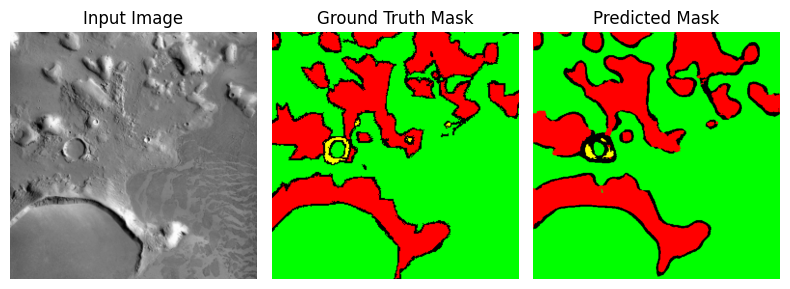

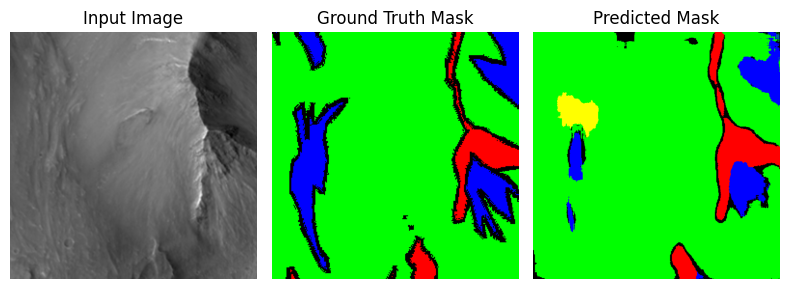

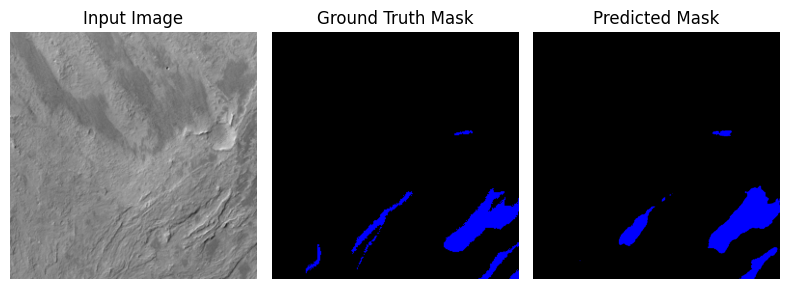

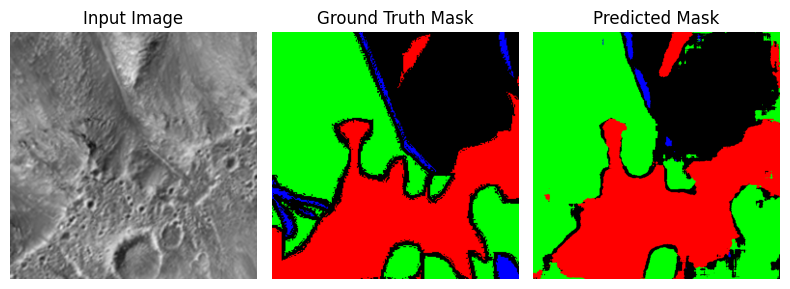

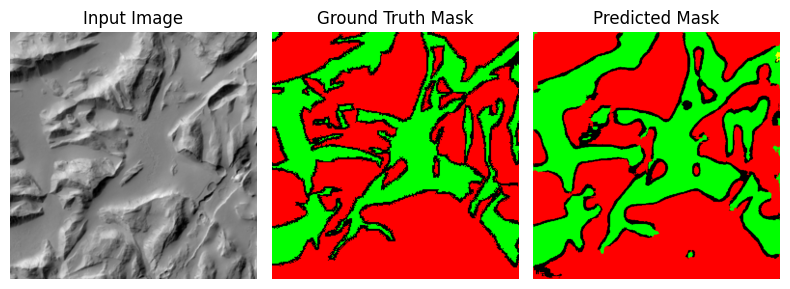

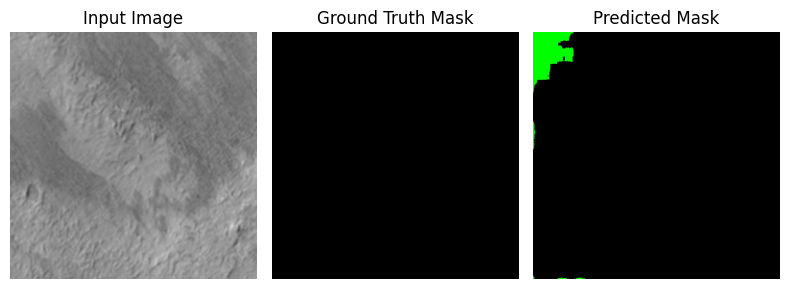

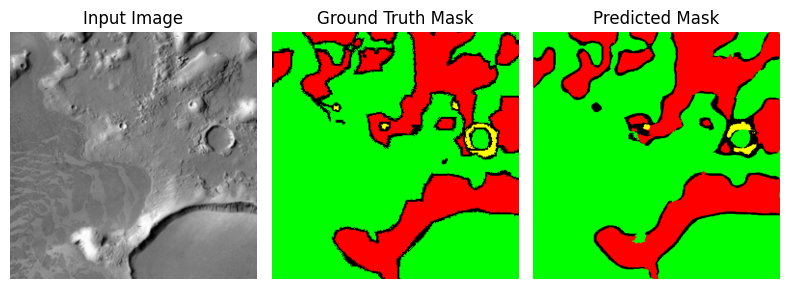

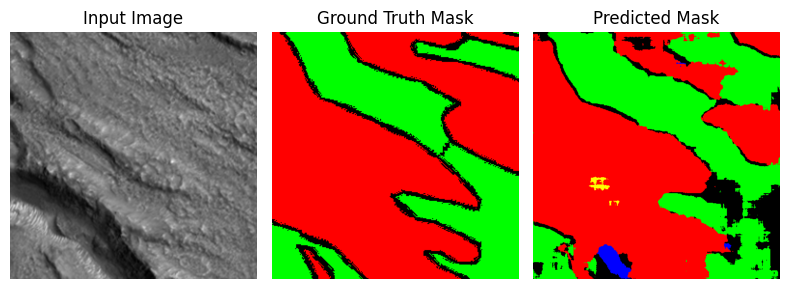

IndexError: index 8 is out of bounds for axis 0 with size 8

In [10]:
# In[7]: Visualize color‐coded predictions vs. ground truth

import matplotlib.pyplot as plt
import numpy as np
import torch

# Define class→RGB colormap
colormap = {
    0: (0, 0, 0),       # background
    1: (255, 255, 0),   # Crater (yellow)
    2: (255, 0, 0),     # Rough (red)
    3: (0, 255, 0),     # Smooth (green)
    4: (0, 0, 255)      # Alluvial_Fan (blue)
}

def decode_mask(mask, colormap):
    """
    Convert 2D class mask to RGB image using colormap.
    mask: H×W array of class indices
    """
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in colormap.items():
        rgb[mask == cls] = color
    return rgb

# Grab a batch from validation loader
model.eval()
imgs, true_masks = next(iter(val_loader))

# Predict
with torch.no_grad():
    logits = model(imgs.to(DEVICE))
    pred_masks = torch.argmax(logits, dim=1).cpu().numpy()

# Prepare images for display: unnormalize
imgs_np = imgs.permute(0, 2, 3, 1).cpu().numpy()  # B×H×W×C
imgs_np = (imgs_np * 0.5) + 0.5                   # back to [0,1]

# Visualize first N samples
N = 30
for i in range(N):
    img = imgs_np[i]
    gt = true_masks[i].numpy()
    pred = pred_masks[i]
    
    gt_color = decode_mask(gt, colormap)
    pred_color = decode_mask(pred, colormap)
    
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))
    axes[0].imshow(img)
    axes[0].set_title("Input Image")
    axes[0].axis('off')
    
    axes[1].imshow(gt_color)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')
    
    axes[2].imshow(pred_color)
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()



In [11]:
# In[7]: Evaluation metrics computation

import time
import numpy as np
import torch
import torch.nn.functional as F

# --- 1. Metric definitions --- #
def compute_confusion_elements(pred, true, class_id):
    """
    Compute TP, FP, FN for one class.
    """
    pred_i = (pred == class_id)
    true_i = (true == class_id)
    tp = np.logical_and(pred_i, true_i).sum()
    fp = np.logical_and(pred_i, ~true_i).sum()
    fn = np.logical_and(~pred_i, true_i).sum()
    return tp, fp, fn

def compute_iou(tp, fp, fn):
    """IoU = TP / (TP + FP + FN)"""  # :contentReference[oaicite:0]{index=0}
    return tp / (tp + fp + fn) if (tp + fp + fn)>0 else 0.0

def compute_dice(tp, fp, fn):
    """Dice = 2·TP / (2·TP + FP + FN)"""  # :contentReference[oaicite:1]{index=1}
    return 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn)>0 else 0.0

def compute_precision(tp, fp):
    """Precision = TP / (TP + FP)"""  # :contentReference[oaicite:2]{index=2}
    return tp / (tp + fp) if (tp + fp)>0 else 0.0

def compute_recall(tp, fn):
    """Recall = TP / (TP + FN)"""  # :contentReference[oaicite:3]{index=3}
    return tp / (tp + fn) if (tp + fn)>0 else 0.0

# --- 2. Evaluation loop --- #
def evaluate_model(model, dataloader, criterion, num_classes=5, device='cpu'):
    model.eval()
    total_loss = 0.0
    total_time = 0.0
    count = 0

    # accumulators per class
    sum_tp = np.zeros(num_classes, dtype=np.int64)
    sum_fp = np.zeros(num_classes, dtype=np.int64)
    sum_fn = np.zeros(num_classes, dtype=np.int64)

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            # inference time measurement best practices :contentReference[oaicite:4]{index=4}
            torch.cuda.synchronize() if device!='cpu' else None
            t0 = time.time()
            logits = model(imgs)
            torch.cuda.synchronize() if device!='cpu' else None
            t1 = time.time()

            total_time += (t1 - t0) * imgs.size(0)
            count += imgs.size(0)

            # loss
            loss = criterion(logits, masks)
            total_loss += loss.item() * imgs.size(0)

            # predictions
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            trues = masks.cpu().numpy()

            # accumulate TP, FP, FN per class
            for c in range(num_classes):
                for p, t in zip(preds, trues):
                    tp, fp, fn = compute_confusion_elements(p, t, c)
                    sum_tp[c] += tp
                    sum_fp[c] += fp
                    sum_fn[c] += fn

    # compute per‑class and mean metrics
    ious, dices, precisions, recalls = [], [], [], []
    for c in range(num_classes):
        iou = compute_iou(sum_tp[c], sum_fp[c], sum_fn[c])
        dice = compute_dice(sum_tp[c], sum_fp[c], sum_fn[c])
        prec = compute_precision(sum_tp[c], sum_fp[c])
        rec = compute_recall(sum_tp[c], sum_fn[c])
        ious.append(iou); dices.append(dice); precisions.append(prec); recalls.append(rec)

    # aggregate
    metrics = {
        'IoU_per_class': ious, 
        'Mean_IoU': np.mean(ious),
        'Dice_per_class': dices,
        'Mean_Dice': np.mean(dices),
        'Precision_per_class': precisions,
        'Mean_Precision': np.mean(precisions),
        'Recall_per_class': recalls,
        'Mean_Recall': np.mean(recalls),
        'Avg_Loss': total_loss / count,       # :contentReference[oaicite:5]{index=5}
        'Avg_Inference_Time': total_time / count
    }
    return metrics

# --- 3. Run evaluation --- #
metrics = evaluate_model(model, val_loader, criterion, num_classes=5, device=DEVICE)

# --- 4. Display results --- #
for k, v in metrics.items():
    print(f"{k}: {v}")


IoU_per_class: [0.8050264890651804, 0.702830851715715, 0.7927392220883482, 0.8801935388747133, 0.6493650120556572]
Mean_IoU: 0.766031022759923
Dice_per_class: [0.8919830195756318, 0.8254852218675347, 0.8843887748100835, 0.9362797187373645, 0.7874121341355877]
Mean_Dice: 0.8651097738252405
Precision_per_class: [0.917712461150859, 0.9376618533597387, 0.8949333048620893, 0.907063598204699, 0.8100511073253833]
Mean_Precision: 0.8934844649805539
Recall_per_class: [0.8676569588802662, 0.737281033440632, 0.8740898324681914, 0.9674405545439017, 0.7660041666202471]
Mean_Recall: 0.8424945091906476
Avg_Loss: 0.2554421305656433
Avg_Inference_Time: 0.36315054893493653
